If you don't have nettack repo cloned clone it (https://github.com/danielzuegner/nettack.git) and go to folder nettack file init.py and add a line there from .nettack import Nettack


In [53]:
import sys
from pathlib import Path

# Add the project root directory to sys.path
sys.path.append(str(Path("/Users/Ola/Desktop/ATDL_A3")))

from nettack.nettack import Nettack

In [54]:
import GNN_module.scripts as scripts #only used for on the fly reloads
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from torch_geometric.nn.models import GAT, GCN
from sklearn.model_selection import ParameterGrid
import numpy as np

from GNN_module.scripts import *
from GNN_module.metrics import *
import torch.nn.functional as F


In [56]:
# Load the Planetoid dataset
dataset_cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset_cora[0]  # Access the single graph in the dataset
labels = data.y

# Prepare GAT model with parameters from your hyperparameter sweeps
s = load_best_sweep('sweeps/sweep_results_gat_cora.pkl')['hyperparameters']
gat = GAT(
    in_channels=data.num_features,
    hidden_channels=s['hidden_channels'] * s['heads'],
    num_layers=s['num_layers'],
    out_channels=dataset_cora.num_classes,  # Use the num_classes attribute directly
    heads=s['heads'],
    dropout=s['dropout'],
    act=F.elu
).to('cpu')

optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)


gatv2 = GAT(v2 = True,
             in_channels=dataset_cora.num_features, 
             hidden_channels=s['hidden_channels']*s['heads'], 
             num_layers=s['num_layers'], 
             out_channels=dataset_cora.num_classes, 
             heads=s['heads'], dropout=s['dropout'], 
             act=F.elu)

optimizer_gatv2 = torch.optim.Adam(gatv2.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [57]:
# Split the indices for training, validation, and testing
idx_train = data.train_mask
idx_val = data.val_mask
idx_test = data.test_mask

# Define a training function
def train():
    gat.train()
    optimizer_gat.zero_grad()
    out = gat(data.x, data.edge_index)  # Pass features and edge_index as input
    loss = criterion(out[idx_train], data.y[idx_train])
    loss.backward()
    optimizer_gat.step()
    return loss.item()

# Training loop
for epoch in range(200):
    loss = train()
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Evaluation
gat.eval()
_, pred = gat(data.x, data.edge_index).max(dim=1)
correct = int(pred[idx_test].eq(data.y[idx_test]).sum().item())
accuracy = correct / int(idx_test.sum())
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1, Loss: 1.9455
Epoch 2, Loss: 1.9450
Epoch 3, Loss: 1.9439
Epoch 4, Loss: 1.9421
Epoch 5, Loss: 1.9410
Epoch 6, Loss: 1.9399
Epoch 7, Loss: 1.9389
Epoch 8, Loss: 1.9389
Epoch 9, Loss: 1.9362
Epoch 10, Loss: 1.9366
Epoch 11, Loss: 1.9327
Epoch 12, Loss: 1.9317
Epoch 13, Loss: 1.9299
Epoch 14, Loss: 1.9296
Epoch 15, Loss: 1.9259
Epoch 16, Loss: 1.9276
Epoch 17, Loss: 1.9205
Epoch 18, Loss: 1.9189
Epoch 19, Loss: 1.9177
Epoch 20, Loss: 1.9168
Epoch 21, Loss: 1.9081
Epoch 22, Loss: 1.9017
Epoch 23, Loss: 1.9030
Epoch 24, Loss: 1.9006
Epoch 25, Loss: 1.8968
Epoch 26, Loss: 1.8929
Epoch 27, Loss: 1.8841
Epoch 28, Loss: 1.8801
Epoch 29, Loss: 1.8739
Epoch 30, Loss: 1.8695
Epoch 31, Loss: 1.8674
Epoch 32, Loss: 1.8611
Epoch 33, Loss: 1.8530
Epoch 34, Loss: 1.8455
Epoch 35, Loss: 1.8303
Epoch 36, Loss: 1.8269
Epoch 37, Loss: 1.8278
Epoch 38, Loss: 1.8168
Epoch 39, Loss: 1.8042
Epoch 40, Loss: 1.7909
Epoch 41, Loss: 1.7812
Epoch 42, Loss: 1.7851
Epoch 43, Loss: 1.7794
Epoch 44, Loss: 1.75

In [58]:
from torch_geometric.nn import GCNConv


class SurrogateGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SurrogateGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x


# Step 3: Train the surrogate model
surrogate_model = SurrogateGCN(in_channels=data.num_features, hidden_channels=16, out_channels=dataset_cora.num_classes)
optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=0.01, weight_decay=5e-4)

surrogate_model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = surrogate_model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Step 4: Extract weights from the surrogate model
state_dict = surrogate_model.state_dict()
W1 = state_dict['conv1.lin.weight'].detach().cpu().numpy().T  # First layer weight
W2 = state_dict['conv2.lin.weight'].detach().cpu().numpy().T  # Second layer weight
u = np.eye(dataset_cora.num_classes)  # Placeholder for the softmax layer


In [59]:
from nettack.nettack import utils
import scipy.sparse as sp


# Convert the PyTorch Geometric data to formats required by Nettack
adj_matrix = data.edge_index
features = data.x.numpy()
labels = data.y.numpy()

# Create adjacency matrix in sparse format
_A_obs = sp.coo_matrix((np.ones(len(adj_matrix[0])), (adj_matrix[0], adj_matrix[1])),
                       shape=(data.num_nodes, data.num_nodes))

# Preprocess the adjacency matrix
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1

# Ensure the largest connected component and preprocess features
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc][:, lcc]
_X_obs = features[lcc].astype('float32')
_z_obs = labels[lcc]
_X_obs = sp.lil_matrix(_X_obs)


Selecting 1 largest connected components


In [60]:
_N = _A_obs.shape[0]
_K = _z_obs.max() + 1
_Z_obs = np.eye(_K)[_z_obs]  # One-hot encoding for labels
sizes = [16, _K]
degrees = _A_obs.sum(0).A1

seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(
    np.arange(_N), train_size=train_share, val_size=val_share,
    test_size=unlabeled_share, stratify=_z_obs
)


In [61]:
# Choose the target node for attack
u = 0  # Change this to the node you want to attack
assert u in split_unlabeled

# Initialize Nettack with the surrogate model weights
nettack = Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

# Define attack parameters
direct_attack = True
n_influencers = 1 if direct_attack else 5
n_perturbations = int(degrees[u])  # Number of perturbations, here set to the node's degree
perturb_features = True
perturb_structure = True

# Perform the attack
nettack.reset()
nettack.attack_surrogate(
    n_perturbations, perturb_structure=perturb_structure,
    perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers
)


##### Starting attack #####
##### Attack node with ID 0 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Feature perturbation: [  0 774]
##### ...2/3 perturbations ... #####
Feature perturbation: [  0 874]
##### ...3/3 perturbations ... #####
Feature perturbation: [ 0 19]


In [62]:
# Set your GAT model to evaluation mode
gat.eval()
with torch.no_grad():
    baseline_logits = gat(data.x, data.edge_index)
    baseline_prediction = baseline_logits[u].argmax().item()

print(f"Baseline prediction for node {u}: {baseline_prediction}")


Baseline prediction for node 0: 3


In [63]:
import torch
import torch.nn.functional as F
import numpy as np

# Define hyperparameters
retrain_iters = 5
classification_margins_clean = []
class_distrs_clean = []

# Train and evaluate GAT model multiple times on clean data
for _ in range(retrain_iters):
    # Reset and train GAT model on clean data
    gat = GAT(
        in_channels=data.num_features,
        hidden_channels=s['hidden_channels'] * s['heads'],
        num_layers=s['num_layers'],
        out_channels=dataset_cora.num_classes,
        heads=s['heads'],
        dropout=s['dropout'],
        act=F.elu
    ).to('cpu')

    optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Training loop (simplified)
    gat.train()
    for epoch in range(100):  # Number of epochs
        optimizer_gat.zero_grad()
        out = gat(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer_gat.step()

    # Evaluate the model on the target node
    gat.eval()
    with torch.no_grad():
        logits = gat(data.x, data.edge_index)
        probs_before_attack = F.softmax(logits[u], dim=0).numpy()
        
        # Store the class distribution and margin for clean data
        class_distrs_clean.append(probs_before_attack)
        best_second_class_before = (probs_before_attack - 1000 * np.eye(dataset_cora.num_classes)[data.y[u]]).argmax()
        margin_before = probs_before_attack[data.y[u]] - probs_before_attack[best_second_class_before]
        classification_margins_clean.append(margin_before)


In [64]:
import torch

# Access perturbed adjacency and feature matrices
perturbed_adj = nettack.adj_preprocessed  # This is typically in sparse matrix format
perturbed_features = nettack.X_obs  # This is also in sparse format (LIL or CSR)

# Convert them to PyTorch tensors if needed
perturbed_adj = torch.tensor(perturbed_adj.toarray(), dtype=torch.float)  # Convert to dense format
perturbed_features = torch.tensor(perturbed_features.toarray(), dtype=torch.float)


In [65]:
# Ensure perturbed_adj is in sparse format
if isinstance(perturbed_adj, torch.Tensor):
    perturbed_adj = sp.csr_matrix(perturbed_adj.numpy())  # Convert back to sparse if needed


In [66]:
from torch_geometric.utils import from_scipy_sparse_matrix

# Convert the perturbed adjacency matrix to a compatible edge_index format
edge_index, edge_weight = from_scipy_sparse_matrix(perturbed_adj)

In [67]:
# Assuming `lcc` is a list of indices for nodes in the largest connected component
train_mask = data.train_mask[lcc]
val_mask = data.val_mask[lcc]
test_mask = data.test_mask[lcc]


In [68]:
# Adjust masks by slicing them to match the node count in `perturbed_features`
train_mask = data.train_mask[:2485]
val_mask = data.val_mask[:2485]
test_mask = data.test_mask[:2485]


In [69]:
subset_y = data.y[lcc]


print(len(train_mask), len(val_mask), len(test_mask), len(subset_y))
print(perturbed_features.shape[0])  # Should match the lengths above

2485 2485 2485 2485
2485


In [70]:
classification_margins_corrupted = []
class_distrs_retrain = []

# Train and evaluate GAT model multiple times on perturbed data
for _ in range(retrain_iters):
    # Reset and train GAT model on perturbed data
    gat = GAT(
        in_channels=data.num_features,
        hidden_channels=s['hidden_channels'] * s['heads'],
        num_layers=s['num_layers'],
        out_channels=dataset_cora.num_classes,
        heads=s['heads'],
        dropout=s['dropout'],
        act=F.elu
    ).to('cpu')

    optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)

    # Training loop
    gat.train()
    for epoch in range(100):  # Number of epochs
        optimizer_gat.zero_grad()
        out = gat(perturbed_features, edge_index)
        loss = criterion(out[train_mask], subset_y[train_mask])
        loss.backward()
        optimizer_gat.step()

    # Evaluate the model on the perturbed node
    gat.eval()
    with torch.no_grad():
        logits = gat(perturbed_features, edge_index)
        probs_after_attack = F.softmax(logits[u], dim=0).numpy()

        # Store the class distribution and margin for perturbed data
        class_distrs_retrain.append(probs_after_attack)
        best_second_class_after = (probs_after_attack - 1000 * np.eye(dataset_cora.num_classes)[subset_y[u]]).argmax()
        margin_after = probs_after_attack[subset_y[u]] - probs_after_attack[best_second_class_after]
        classification_margins_corrupted.append(margin_after)


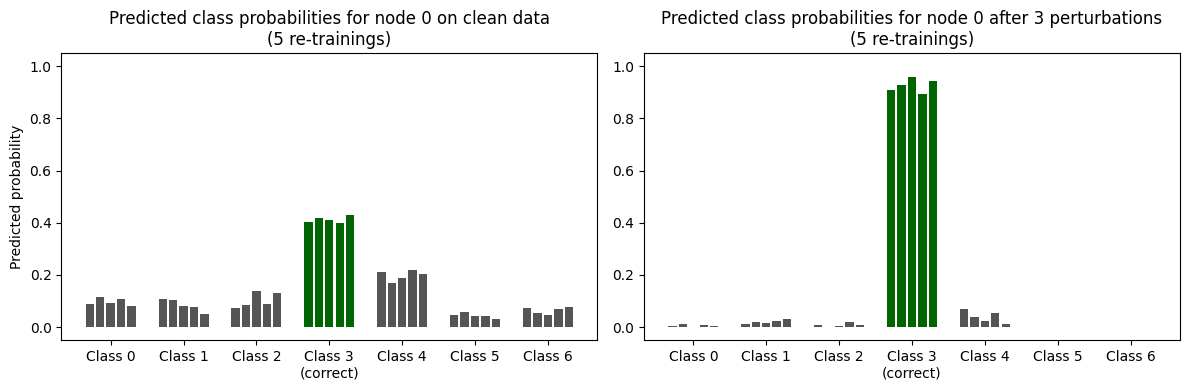

In [71]:
import matplotlib.pyplot as plt

def make_xlabel(ix, correct):
    if ix == correct:
        return f"Class {ix}\n(correct)"
    return f"Class {ix}"

# Plot the clean and perturbed class distributions
figure = plt.figure(figsize=(12, 4))

# Clean data visualization
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(np.array(class_distrs_clean).T):
    x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = 'darkgreen' if ix == data.y[u] else '#555555'
    plt.bar(x_ixs, block, color=color)
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
plt.xticks(center_ixs_clean, [make_xlabel(k, data.y[u]) for k in range(dataset_cora.num_classes)])
plt.title(f"Predicted class probabilities for node {u} on clean data\n({retrain_iters} re-trainings)")

# Perturbed data visualization
plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(np.array(class_distrs_retrain).T):
    x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = 'darkgreen' if ix == data.y[u] else '#555555'
    plt.bar(x_ixs, block, color=color)
plt.ylim((-.05, 1.05))
plt.xticks(center_ixs_retrain, [make_xlabel(k, data.y[u]) for k in range(dataset_cora.num_classes)])
plt.title(f"Predicted class probabilities for node {u} after {n_perturbations} perturbations\n({retrain_iters} re-trainings)")
plt.tight_layout()
plt.show()


In [74]:
def train_and_evaluate(model_class, data, edge_index, features, labels, train_mask, val_mask, test_mask, hyperparameters, retrain_iters=5, epochs=100, lr=0.005, v2=False):
    classification_margins = []
    class_distributions = []

    act = hyperparameters.get('act', F.elu)


    for _ in range(retrain_iters):
        # Initialize the model with the sweep-based hyperparameters and version flag
        model = model_class(
            v2=v2,
            in_channels=features.size(1),
            hidden_channels=hyperparameters['hidden_channels'] * hyperparameters['heads'],
            num_layers=hyperparameters['num_layers'],
            out_channels=labels.max().item() + 1,
            heads=hyperparameters['heads'],
            dropout=hyperparameters['dropout'],
            act=act
        ).to('cpu')

        optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(features, edge_index)
            loss = criterion(out[train_mask], labels[train_mask])
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            logits = model(features, edge_index)
            probs = F.softmax(logits[u], dim=0).numpy()

            # Calculate margins
            best_second_class = (probs - 1000 * np.eye(labels.max().item() + 1)[labels[u]]).argmax()
            margin = probs[labels[u]] - probs[best_second_class]

            # Store results
            class_distributions.append(probs)
            classification_margins.append(margin)

    return classification_margins, class_distributions


In [75]:
# Load hyperparameters from sweeps for both GAT and GATv2
hyperparameters_gat = load_best_sweep('sweeps/sweep_results_gat_cora.pkl')['hyperparameters']
hyperparameters_gatv2 = load_best_sweep('sweeps/sweep_results_gatv2_cora.pkl')['hyperparameters']


In [37]:
# Baseline: GAT on clean data
classification_margins_gat_clean, class_distributions_gat_clean = train_and_evaluate(
    GAT, data, data.edge_index, data.x, data.y, data.train_mask, data.val_mask, data.test_mask,
    hyperparameters=hyperparameters_gat, v2=False
)

# Baseline: GATv2 on clean data
classification_margins_gatv2_clean, class_distributions_gatv2_clean = train_and_evaluate(
    GAT, data, data.edge_index, data.x, data.y, data.train_mask, data.val_mask, data.test_mask,
    hyperparameters=hyperparameters_gatv2, v2=True
)


In [51]:
# GAT on perturbed data
classification_margins_gat_perturbed, class_distributions_gat_perturbed = train_and_evaluate(
    GAT, data, edge_index, perturbed_features, subset_y, train_mask, val_mask, test_mask,
    hyperparameters=hyperparameters_gat, v2=False
)

# GATv2 on perturbed data
classification_margins_gatv2_perturbed, class_distributions_gatv2_perturbed = train_and_evaluate(
    GAT, data, edge_index, perturbed_features, subset_y, train_mask, val_mask, test_mask,
    hyperparameters=hyperparameters_gatv2, v2=True
)


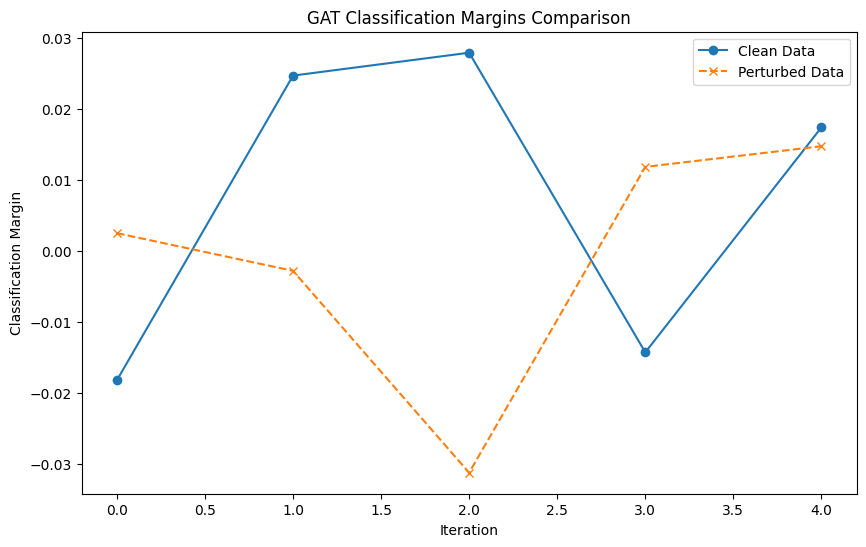

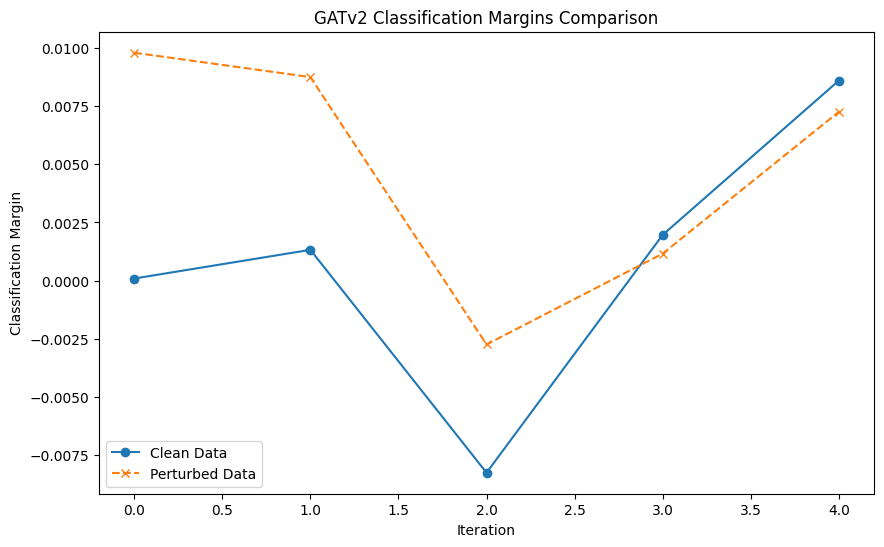

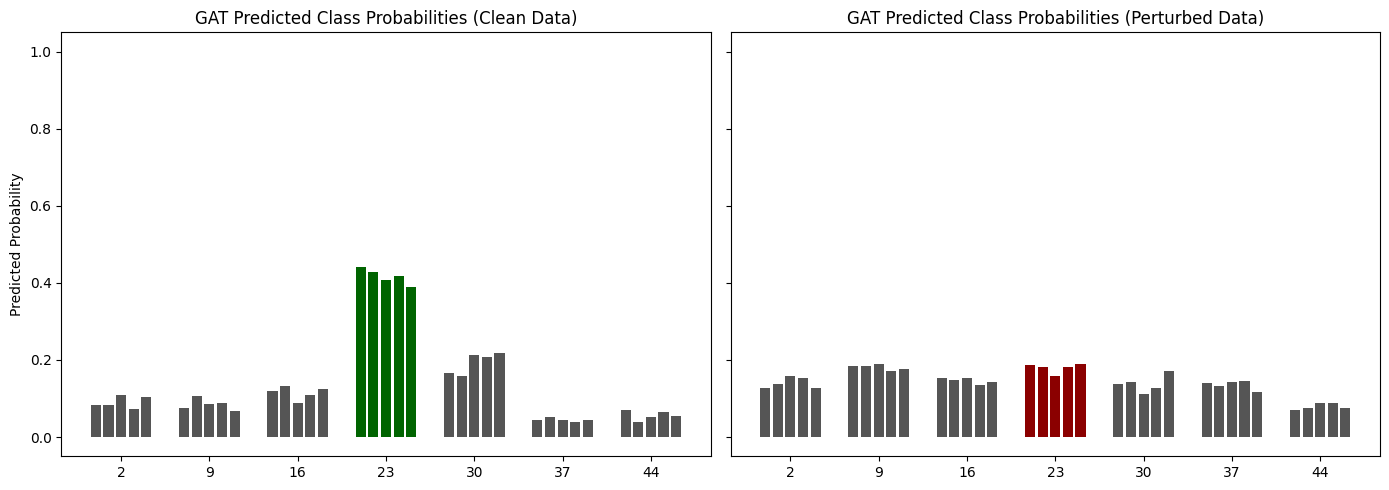

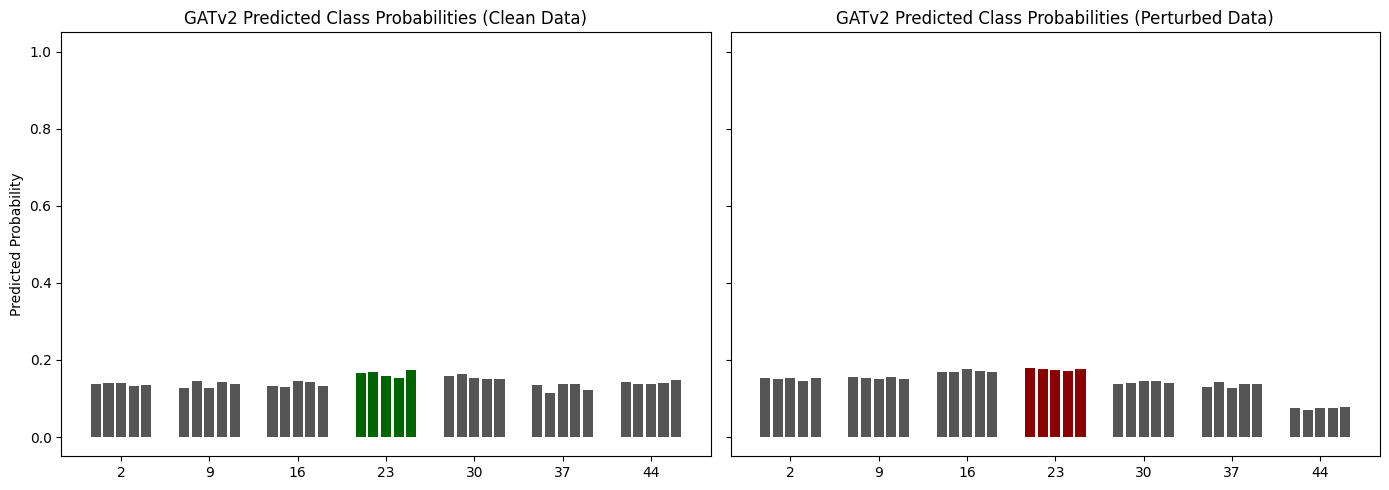

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Define a helper function for margin plot
def plot_margins(margins_clean, margins_perturbed, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(margins_clean, label="Clean Data", marker='o')
    plt.plot(margins_perturbed, label="Perturbed Data", linestyle="--", marker='x')
    plt.xlabel("Iteration")
    plt.ylabel("Classification Margin")
    plt.title(f"{model_name} Classification Margins Comparison")
    plt.legend()
    plt.show()

# Plot classification margins for GAT
plot_margins(classification_margins_gat_clean, classification_margins_gat_perturbed, "GAT")

# Plot classification margins for GATv2
plot_margins(classification_margins_gatv2_clean, classification_margins_gatv2_perturbed, "GATv2")

# Define a helper function for class probability distributions
def plot_class_distributions(class_distr_clean, class_distr_perturbed, labels, model_name):
    num_classes = len(class_distr_clean[0])
    class_labels = np.arange(num_classes)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    # Plot clean distribution
    center_ixs_clean = []
    for ix, block in enumerate(np.array(class_distr_clean).T):
        x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
        center_ixs_clean.append(np.mean(x_ixs))
        color = 'darkgreen' if ix == labels else '#555555'
        axes[0].bar(x_ixs, block, color=color)
    axes[0].set_ylim((-.05, 1.05))
    axes[0].set_ylabel("Predicted Probability")
    axes[0].set_xticks(center_ixs_clean)
    axes[0].set_title(f"{model_name} Predicted Class Probabilities (Clean Data)")

    # Plot perturbed distribution
    center_ixs_perturbed = []
    for ix, block in enumerate(np.array(class_distr_perturbed).T):
        x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
        center_ixs_perturbed.append(np.mean(x_ixs))
        color = 'darkred' if ix == labels else '#555555'
        axes[1].bar(x_ixs, block, color=color)
    axes[1].set_ylim((-.05, 1.05))
    axes[1].set_xticks(center_ixs_perturbed)
    axes[1].set_title(f"{model_name} Predicted Class Probabilities (Perturbed Data)")
    
    plt.tight_layout()
    plt.show()

# Plot class distributions for GAT
plot_class_distributions(class_distributions_gat_clean, class_distributions_gat_perturbed, data.y[u], "GAT")

# Plot class distributions for GATv2
plot_class_distributions(class_distributions_gatv2_clean, class_distributions_gatv2_perturbed, data.y[u], "GATv2")


In [41]:
import random


# Assuming `perturbed_features` has the shape of the perturbed graph's node count
max_node_index = perturbed_features.size(0) - 1
# Define the number of nodes to evaluate
num_samples = 10
target_nodes = torch.randint(0, max_node_index + 1, (num_samples,))


# Initialize lists to store results across nodes
classification_margins_gat_clean_all = []
classification_margins_gat_perturbed_all = []
classification_margins_gatv2_clean_all = []
classification_margins_gatv2_perturbed_all = []

for u in target_nodes:
    # Run evaluation for GAT and GATv2 on the clean and perturbed data for each node `u`
    
    # GAT on clean data
    classification_margins_gat_clean, _ = train_and_evaluate(
        GAT, data, data.edge_index, data.x, data.y, data.train_mask, data.val_mask, data.test_mask,
        hyperparameters=hyperparameters_gat, v2=False
    )
    
    # GAT on perturbed data
    classification_margins_gat_perturbed, _ = train_and_evaluate(
        GAT, data, edge_index, perturbed_features, subset_y, train_mask, val_mask, test_mask,
        hyperparameters=hyperparameters_gat, v2=False
    )

    # GATv2 on clean data
    classification_margins_gatv2_clean, _ = train_and_evaluate(
        GAT, data, data.edge_index, data.x, data.y, data.train_mask, data.val_mask, data.test_mask,
        hyperparameters=hyperparameters_gatv2, v2=True
    )
    
    # GATv2 on perturbed data
    classification_margins_gatv2_perturbed, _ = train_and_evaluate(
        GAT, data, edge_index, perturbed_features, subset_y, train_mask, val_mask, test_mask,
        hyperparameters=hyperparameters_gatv2, v2=True
    )

    # Aggregate margins for each node
    classification_margins_gat_clean_all.append(classification_margins_gat_clean)
    classification_margins_gat_perturbed_all.append(classification_margins_gat_perturbed)
    classification_margins_gatv2_clean_all.append(classification_margins_gatv2_clean)
    classification_margins_gatv2_perturbed_all.append(classification_margins_gatv2_perturbed)

# Calculate average margins for each model and condition
avg_gat_clean = np.mean(classification_margins_gat_clean_all)
avg_gat_perturbed = np.mean(classification_margins_gat_perturbed_all)
avg_gatv2_clean = np.mean(classification_margins_gatv2_clean_all)
avg_gatv2_perturbed = np.mean(classification_margins_gatv2_perturbed_all)

print("Average Classification Margins for GAT (Clean):", avg_gat_clean)
print("Average Classification Margins for GAT (Perturbed):", avg_gat_perturbed)
print("Average Classification Margins for GATv2 (Clean):", avg_gatv2_clean)
print("Average Classification Margins for GATv2 (Perturbed):", avg_gatv2_perturbed)


Average Classification Margins for GAT (Clean): 0.08170083
Average Classification Margins for GAT (Perturbed): 0.15198457
Average Classification Margins for GATv2 (Clean): 0.004513429
Average Classification Margins for GATv2 (Perturbed): 0.011786617


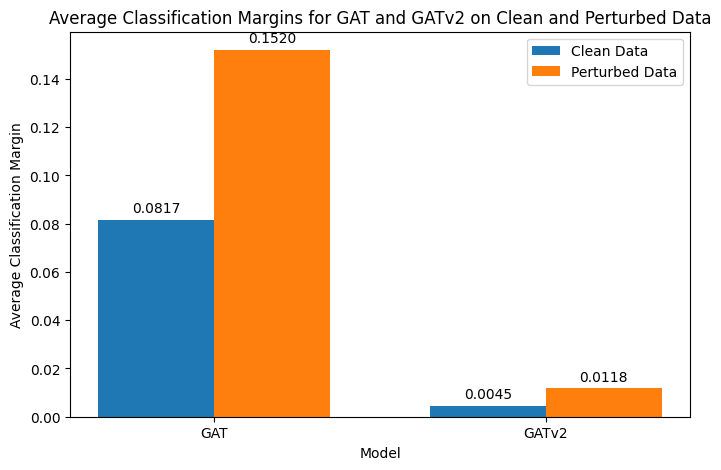

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['GAT', 'GATv2']
clean_margins = [avg_gat_clean, avg_gatv2_clean]
perturbed_margins = [avg_gat_perturbed, avg_gatv2_perturbed]

# Create a bar plot
x = np.arange(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, clean_margins, width, label='Clean Data')
bars2 = ax.bar(x + width/2, perturbed_margins, width, label='Perturbed Data')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Average Classification Margin')
ax.set_title('Average Classification Margins for GAT and GATv2 on Clean and Perturbed Data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the values on top of each bar for clarity
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


/var/folders/tf/1b9ww3w15_g2r2jv_lv16k8h0000gp/T/ipykernel_95246/3791115792.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


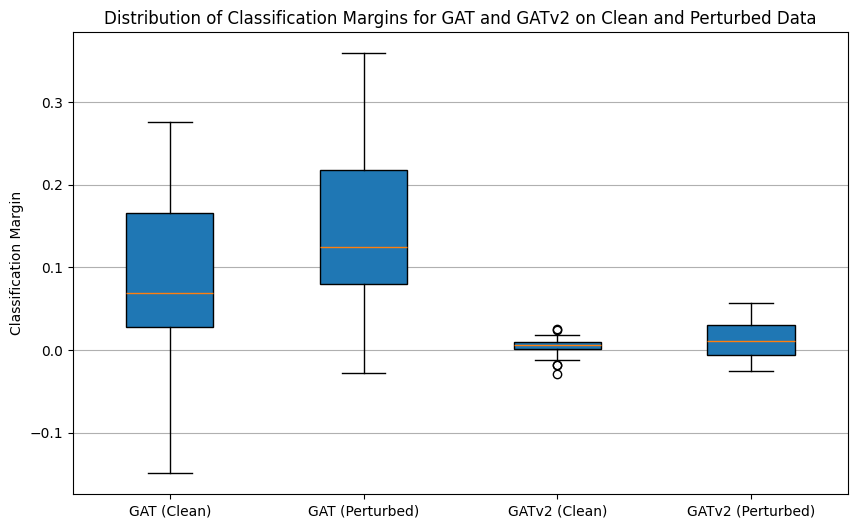

In [44]:
# Flatten each list of classification margins across nodes
data = [
    np.concatenate(classification_margins_gat_clean_all).ravel(),
    np.concatenate(classification_margins_gat_perturbed_all).ravel(),
    np.concatenate(classification_margins_gatv2_clean_all).ravel(),
    np.concatenate(classification_margins_gatv2_perturbed_all).ravel()
]

labels = [
    'GAT (Clean)', 
    'GAT (Perturbed)', 
    'GATv2 (Clean)', 
    'GATv2 (Perturbed)'
]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)
plt.ylabel('Classification Margin')
plt.title('Distribution of Classification Margins for GAT and GATv2 on Clean and Perturbed Data')
plt.grid(axis='y')

plt.show()
